# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


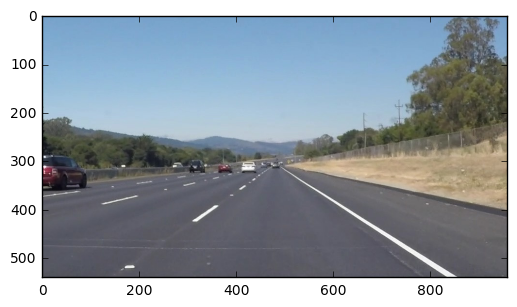

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    right_line_points = []
    left_line_points = []
    
    # Split lines up into left and right lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope > 0:
                #if slope > .3:
                    #right_line_slopes.append(slope) initial idea
                right_line_points.append([x1,y1,x2,y2]) 
            else:
                #if slope < -.3:
                    #left_line_slopes.append(slope) initial idea
                left_line_points.append([x1,y1,x2,y2]) 
    
    # Convert line arrays to np array
    left_line = np.array(left_line_points)
    right_line = np.array(right_line_points)
    
    # Right Lines
    # Calculate the min and max for the right line
    right_line_x1 = get_column_min(right_line, 0)
    right_line_y1 = get_column_min(right_line, 1)
    right_line_x2 = get_column_max(right_line, 2)
    right_line_y2 = get_column_max(right_line, 3)
    
    # Calculate the averages for the right line
    right_line_x1_average = get_column_average(right_line, 0)
    right_line_y1_average = get_column_average(right_line, 1)
    right_line_x2_average = get_column_average(right_line, 2)
    right_line_y2_average = get_column_average(right_line, 3)
    
    # Calculate the average slope ((y2-y1)/(x2-x1))
    right_line_slope = ((right_line_y2_average - right_line_y1_average) / (right_line_x2_average - right_line_x1_average))
    
    # Apply the slope for the extrapolation
    right_y1 = 320
    right_x1 = int(right_line_x1_average + (right_y1 - right_line_y1_average) / right_line_slope)
    right_y2 = 550
    right_x2 = int(right_line_x1_average + (right_y2 - right_line_y1_average) / right_line_slope)
    
    # Draw the extrapolated line for the right line
    cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    
    # Left Line
    # Calculate the min and max for the left line
    left_line_x1 = get_column_min(left_line, 0)
    left_line_y1 = get_column_min(left_line, 1)
    left_line_x2 = get_column_max(left_line, 2)
    left_line_y2 = get_column_max(left_line, 3)
    
    # Calculate the averages for the left line
    left_line_x1_average = get_column_average(left_line, 0)
    left_line_y1_average = get_column_average(left_line, 1)
    left_line_x2_average = get_column_average(left_line, 2)
    left_line_y2_average = get_column_average(left_line, 3)

    # Calculate the average slope for the left line ((y2-y1)/(x2-x1))
    left_line_slope = ((left_line_y2_average - left_line_y1_average) / (left_line_x2_average - left_line_x1_average))
    
    # Apply the slope for the extrapolation for left line
    left_y1 = 320
    left_x1 = int(left_line_x1_average + (left_y1 - left_line_y1_average) / left_line_slope)
    left_y2 = 545
    left_x2 = int(left_line_x1_average + (left_y2 - left_line_y1_average) / left_line_slope)
    
    # Draw the extrapolated line for the left line
    cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), [0,255,0], thickness)
       

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def get_column_average(np_array, column):
    column = np_array[:, column]
    return np.mean(column)
    
def get_column_min(np_array, column):
    column = np_array[:, column]
    return np.min(column)
    
def get_column_max(np_array, column):
    column = np_array[:, column]
    return np.max(column)

def pipeline(directory, initial_image):
    
    # Read in and greyscale the image
    image_path = directory + initial_image
    image = mpimg.imread(image_path)
    grayscale_image = grayscale(image)

    # Define kernel size and apply Gaussian smoothing
    kernel_size = 3
    gb_greyscale_image = gaussian_blur(grayscale_image, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges_image = canny(gb_greyscale_image, low_threshold, high_threshold)

    # Define region of choice
    image_shape = image.shape
    vertices = np.array([[(0,image_shape[0]),(450, 320), (550, 320), (image_shape[1],image_shape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges_image, vertices)

    # Define the Hough transform parameters
    rho = 2
    theta = np.pi/180
    threshold = 25
    min_line_len = 25
    max_line_gap = 12

    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)

    #print(image.shape)
    #print(line_image.shape)
    weighted = weighted_img(line_image, image)
    plt.imshow(weighted)
    
    # Save the weighted image in the directory
    image_name = directory + "weighted_" + initial_image
    mpimg.imsave(image_name, weighted)



## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'weighted_solidWhiteCurve.jpg', 'weighted_solidWhiteRight.jpg', 'weighted_solidYellowCurve.jpg', 'weighted_solidYellowCurve2.jpg', 'weighted_solidYellowLeft.jpg', 'weighted_whiteCarLaneSwitch.jpg', 'whiteCarLaneSwitch.jpg']


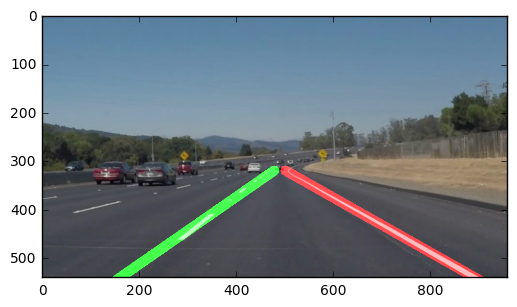

In [5]:
import os
print(os.listdir("test_images/"))

pipeline("test_images/", "solidWhiteCurve.jpg")


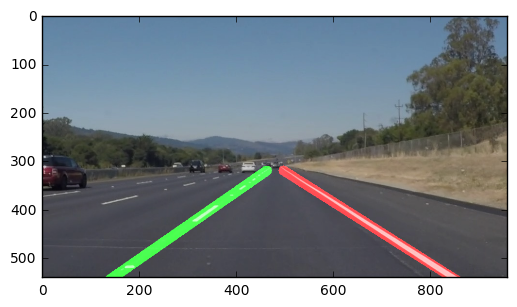

In [6]:
pipeline("test_images/", "solidWhiteRight.jpg")


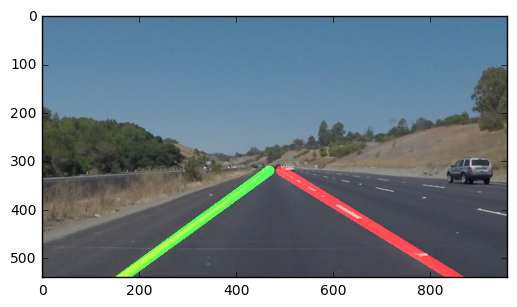

In [7]:
pipeline("test_images/", "solidYellowCurve.jpg")

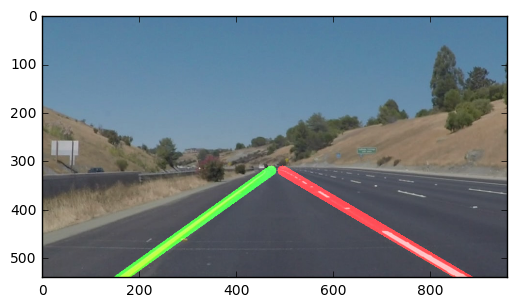

In [8]:
pipeline("test_images/", "solidYellowCurve2.jpg")

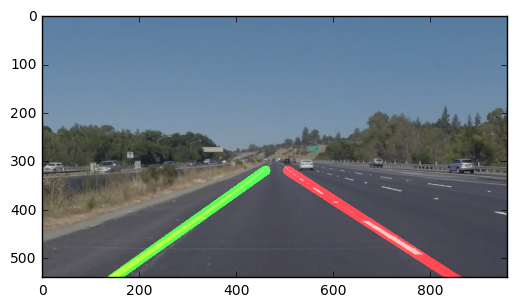

In [9]:
pipeline("test_images/", "solidYellowLeft.jpg")

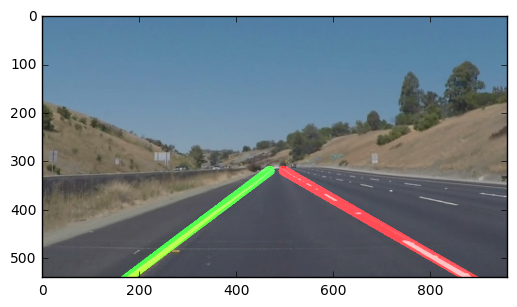

In [10]:
pipeline("test_images/", "whiteCarLaneSwitch.jpg")

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [89]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    grayscale_image = grayscale(image)

    # Define kernel size and apply Gaussian smoothing
    kernel_size = 3
    gb_greyscale_image = gaussian_blur(grayscale_image, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges_image = canny(gb_greyscale_image, low_threshold, high_threshold)

    # Define region of choice
    image_shape = image.shape
    vertices = np.array([[(0,image_shape[0]),(450, 320), (550, 320), (image_shape[1],image_shape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges_image, vertices)

    # Define the Hough transform parameters
    rho = 2
    theta = np.pi/180
    threshold = 82
    min_line_len = 35
    max_line_gap = 50

    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)

    result = weighted_img(line_image, image)
    return result

Let's try the one with the solid white lane on the right first ...

In [90]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4










  0%|          | 0/222 [00:00<?, ?it/s]







  5%|▍         | 11/222 [00:00<00:01, 106.98it/s]







 10%|▉         | 22/222 [00:00<00:01, 105.65it/s]







 15%|█▌        | 34/222 [00:00<00:01, 108.69it/s]







 20%|██        | 45/222 [00:00<00:01, 106.35it/s]







 24%|██▍       | 54/222 [00:00<00:02, 74.18it/s] 







 27%|██▋       | 61/222 [00:00<00:02, 69.49it/s]







 31%|███       | 68/222 [00:00<00:02, 63.43it/s]







 34%|███▍      | 75/222 [00:01<00:02, 59.46it/s]







 36%|███▋      | 81/222 [00:01<00:02, 58.05it/s]







 39%|███▉      | 87/222 [00:01<00:02, 57.54it/s]







 43%|████▎     | 95/222 [00:01<00:02, 62.20it/s]







 46%|████▌     | 102/222 [00:01<00:01, 62.70it/s]







 49%|████▉     | 109/222 [00:01<00:01, 63.01it/s]







 52%|█████▏    | 116/222 [00:01<00:01, 60.02it/s]







 55%|█████▌    | 123/222 [00:01<00:01, 59.33it/s]







 58%|█████▊    | 129/222 [00:01<00:01, 58.03it/s]







 61%|██████▏   | 136/222 [00:02<00:01, 

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1.54 s, sys: 173 ms, total: 1.71 s
Wall time: 4.19 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [91]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [92]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4










  0%|          | 0/682 [00:00<?, ?it/s]







  1%|▏         | 10/682 [00:00<00:06, 96.05it/s]







  3%|▎         | 21/682 [00:00<00:06, 98.58it/s]







  5%|▍         | 32/682 [00:00<00:06, 101.08it/s]







  6%|▌         | 42/682 [00:00<00:06, 99.50it/s] 







  7%|▋         | 50/682 [00:00<00:08, 73.21it/s]







  8%|▊         | 57/682 [00:00<00:09, 68.90it/s]







  9%|▉         | 64/682 [00:00<00:09, 67.10it/s]







 10%|█         | 71/682 [00:00<00:09, 66.23it/s]







 11%|█▏        | 78/682 [00:01<00:09, 64.80it/s]







 12%|█▏        | 85/682 [00:01<00:09, 62.05it/s]







 13%|█▎        | 92/682 [00:01<00:10, 58.20it/s]







 14%|█▍        | 98/682 [00:01<00:10, 54.03it/s]







 15%|█▌        | 104/682 [00:01<00:11, 50.84it/s]







 16%|█▌        | 110/682 [00:01<00:11, 48.88it/s]







 17%|█▋        | 115/682 [00:01<00:12, 46.98it/s]







 18%|█▊        | 122/682 [00:01<00:10, 51.14it/s]







 19%|█▉        | 128/682 [00:02<00:11, 49.9

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 4.67 s, sys: 485 ms, total: 5.15 s
Wall time: 10.6 s


In [93]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

Initial thoughts... I've got a lot to learn! I think my solution is pretty crude... an awful lot of guess work brought this to fruition and it makes me feel incredibly uncomfortable. This I know is a good thing, because it means I am learning. Every part of this was an ah ha moment and for that I am excited to move forward and look back on this in a few weeks and think to myself... you thought that was hard! 

There are alot more things I would like to do with my current pipeline. I made a few guesses around outliers and this could be much more acurate. Additionally, I would like to perhaps use a different method to extrapolate the line... I look at cv2.fitlines and thought that this might be a better way to go... I know when it comes to harder conditions such as curves in the road, my solution will fail. 

This is by no means a solution that is robust... but hey a few days ago I had no idea how to do any of this. It's very cool! 

I will now spend the rest of the week trying to see if I can improve my solutions / change completely to be able to meet the robustness of the Optional Challenge.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [94]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4










  0%|          | 0/251 [00:00<?, ?it/s]







  2%|▏         | 5/251 [00:00<00:05, 44.99it/s]







  4%|▍         | 10/251 [00:00<00:05, 45.55it/s]







  6%|▌         | 15/251 [00:00<00:05, 45.15it/s]







  8%|▊         | 19/251 [00:00<00:05, 42.01it/s]







  9%|▉         | 23/251 [00:00<00:05, 41.04it/s]







 11%|█         | 27/251 [00:00<00:05, 40.68it/s]







 13%|█▎        | 32/251 [00:00<00:05, 41.34it/s]







 15%|█▍        | 37/251 [00:00<00:05, 42.55it/s]







 17%|█▋        | 42/251 [00:00<00:04, 43.68it/s]







 19%|█▊        | 47/251 [00:01<00:07, 28.64it/s]







 20%|██        | 51/251 [00:01<00:07, 25.34it/s]







 22%|██▏       | 54/251 [00:01<00:08, 23.18it/s]







 23%|██▎       | 57/251 [00:01<00:08, 22.53it/s]







 24%|██▍       | 60/251 [00:01<00:08, 21.31it/s]







 25%|██▌       | 63/251 [00:02<00:09, 20.84it/s]







 26%|██▋       | 66/251 [00:02<00:08, 22.62it/s]







 27%|██▋       | 69/251 [00:02<00:07, 24.30it/s]



[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 4.98 s, sys: 349 ms, total: 5.33 s
Wall time: 10.2 s


In [95]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))